Using Eq. (7) from [here](https://pubs.acs.org/doi/10.1021/acsphotonics.9b01649) (see also [here](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.9.021057)), the 
coupling strength two a given mode $\alpha$ is inversely proportional to its volume:
\begin{equation} 
\lambda_{\alpha} = \sqrt{\frac{4 \pi}{V}},
\end{equation}
and the effective coupling strength resulting from $N_p$ photon modes (with the same polarization) goes as
\begin{equation}
\lambda_{eff}^2 = \sum_{\alpha}^{N_p} \lambda_{\alpha}^2.
\end{equation}


In [1]:
import numpy as np
# half wavelength of a 10.4 eV photon in nm
lam_0_nm = 119/2.
# conversion from nm to atomic units of length
nm_to_au = 18.8973
# wavelength of a 10.4 eV photon in a.u.
lam_0_au = lam_0_nm * nm_to_au

# go from L to \lambda
def lam_from_L(L, Np):
    l_a = np.sqrt(4 * np.pi / L**3)
    return np.sqrt(Np) * l_a

# go from \lambda to V_{eff}
def V_from_lam(lam, Np):
    lam_single = lam / np.sqrt(Np)
    return np.pi * 4 / lam_single ** 2


#L_vals = np.linspace(lam_0_au, lam_0_au/100, 20)
#V_vals = L_vals ** 3
lam_vals = np.array([1e-2, 2e-2, 4e-2, 8e-2, 1.6e-1, 3.2e-1, 6.4e-1, 12.8e-1]) #1.8e-1, 2.0e-1, 2.2e-1, 2.4e-1, 2.6e-1, 2.8e-1, 3.0e-1])
print(lam_vals)
V_vals = V_from_lam(lam_vals, 100)
L_vals = V_vals ** (1/3) / 18.8973

print(L_vals)
print(lam_vals)

[0.01 0.02 0.04 0.08 0.16 0.32 0.64 1.28]
[12.30278772  7.75027061  4.88236454  3.07569693  1.93756765  1.22059114
  0.76892423  0.48439191]
[0.01 0.02 0.04 0.08 0.16 0.32 0.64 1.28]


In [2]:
import numpy as np
from matplotlib import pyplot as plt

from __future__ import print_function

"""
A script to run cqed_rhf method on the formaldehyde coupled to a photon with 
different polarizations and coupling magnitude |\lambda| = 0.2 atomic units
to produce data from Table I of McTague and Foley 
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cs_cqed_cis import *
from matplotlib import pyplot as plt

# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2

# rhf/cc-pVDZ optimized geometry of formaldehyde
#molstr = """

#0 1
#O 0.0000000000 0.0000000000 5.91268220e-01
#C 0.0000000000 0.0000000000 -5.90400099e-01
#H 0.0000000000 9.32184336e-01 -1.17703144e+00
#H 0.0000000000 -9.32184336e-01 -1.17703144e+00
#no_reorient
#symmetry c1
#"""


molstr = """

0 1
O     2.840870040183  -0.387983947380  -0.000140928146
C     0.557801982924   0.238180751028  -0.000084684017
C    -0.354783520778   1.295787967045  -0.000056358537
C     0.088762332125  -1.079477935991  -0.000064978940
C    -1.716063504039   1.036759893865   0.000005724586
C    -1.271559360844  -1.333435990096  -0.000018654238
C    -2.173947778498  -0.275561724588   0.000020424018
C     2.012592370259   0.486079561440  -0.000154503817
H     0.006734863975   2.319157700150  -0.000066807670
H     0.809759189789  -1.889984403061  -0.000097277747
H    -2.424203535688   1.857848520190   0.000026752818
H    -1.634699644168  -2.354990105448  -0.000003081663
H    -3.239960718971  -0.474282877619   0.000059476661
H     2.291397280628   1.561802584215  -0.000225102884
no_reorient
symmetry c1
"""
# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 5e-7,
               'd_convergence' : 5e-6}




  Memory set to   1.863 GiB by Python driver.


In [3]:

# dipole self energy vs rho
dse = []

# dipole-dipole energy from rhf dipole (no cavity effect)
dde_rhf = []

# dipole-dipole energy from cqed-rhf dipole (cavity effect included)
dde_cqed_rhf = []

no_lam = np.array([0, 0, 0])

# this will get the rhf result because there is no cavity effect
rhf_dict = cqed_rhf(no_lam, molstr, options_dict)

# scan through number of molecules in the cavity and compute 
# g(\rho), \mu(\rho), d_q(\rho), and \lambda(\rho)
oereps = 4 * np.pi
for l in lam_vals:

    #lam.append( l )
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("lambda is ",l)
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    
    # get the volume of the cavity for this \lambda value
    V_val = V_from_lam(l, 100)
    # get the L of the cavity from this V
    L_val = V_val ** (1/3) 
    # get the separation between monomers from L/2
    r = L_val / 2
    
    # define lambda vector as pointing along y and z
    lam_yz = np.array([0, l/np.sqrt(2), l/np.sqrt(2)])
    
    # run cqed-rhf calculation with lam_yz
    cqed_dict_yz = cqed_rhf(lam_yz, molstr, options_dict)
    
    # get RHF dipole-dipole energy
    mu_rhf = cqed_dict_yz['RHF DIPOLE MOMENT']
    mu_dot_mu = np.dot(mu_rhf, mu_rhf)
    dde_rhf.append(mu_dot_mu * oereps / (r **3) )
    
    # get CQED-RHF dipole-dipole energy
    mu_cqed_rhf = cqed_dict_yz['CQED-RHF DIPOLE MOMENT']
    mu_dot_mu = np.dot(mu_cqed_rhf, mu_cqed_rhf)
    dde_cqed_rhf.append(mu_dot_mu * oereps / (r **3))
    
    # get dipole self energy
    d_q = cqed_dict_yz["1E DIPOLE ENERGY"] + cqed_dict_yz["2E DIPOLE ENERGY"]
    d_q += cqed_dict_yz["1E QUADRUPOLE ENERGY"] + cqed_dict_yz["DIPOLE ENERGY"]

    dse.append(d_q)
    




Start SCF iterations:

Canonical RHF One-electron energy = -1104.1842644113087317
CQED-RHF One-electron energy      = -1104.1842644113087317
Nuclear repulsion energy          = 322.3342066857324539
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -343.4606503067304288   dE = -3.43461E+02   dRMS = 2.72939E-07
SCF Iteration   2: Energy = -343.4606503096500205   dE = -2.91959E-09   dRMS = 1.79837E-07
Total time for SCF iterations: 3.577 seconds 

QED-RHF   energy: -343.46065031 hartree
Psi4  SCF energy: -343.46065029 hartree
!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!
lambda is  0.01
!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!

Start SCF iterations:

Canonical RHF One-electron energy = -1104.1842644113087317
CQED-RHF One-electron energy      = -1104.1774030766155192
Nuclear repulsion energy          = 322.3342066857324539
Dipole energy                     = 0.0000042607302029
SCF Iteration   1: Energy = -343.4591399538344945   dE = -3.43459E+

SCF Iteration  19: Energy = -342.0708953723781747   dE = -4.24442E-07   dRMS = 7.07491E-06
SCF Iteration  20: Energy = -342.0708956619958485   dE = -2.89618E-07   dRMS = 5.71425E-06
SCF Iteration  21: Energy = -342.0708958601427412   dE = -1.98147E-07   dRMS = 5.02115E-06
SCF Iteration  22: Energy = -342.0708959960582547   dE = -1.35916E-07   dRMS = 4.06777E-06
Total time for SCF iterations: 39.638 seconds 

QED-RHF   energy: -342.07089600 hartree
Psi4  SCF energy: -343.46065029 hartree
!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!
lambda is  0.64
!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!

Start SCF iterations:

Canonical RHF One-electron energy = -1104.1842644113087317
CQED-RHF One-electron energy      = -1076.0802375082541857
Nuclear repulsion energy          = 322.3342066857324539
Dipole energy                     = 0.0174519509109866
SCF Iteration   1: Energy = -337.2742448427921431   dE = -3.37274E+02   dRMS = 1.29400E-02
SCF Iteration   2: Energy = -338.48643830248687

SCF Iteration  35: Energy = -328.8497556266884772   dE = -2.22549E-04   dRMS = 4.47044E-04
SCF Iteration  36: Energy = -328.8499484208961121   dE = -1.92794E-04   dRMS = 4.03108E-04
SCF Iteration  37: Energy = -328.8501159693572617   dE = -1.67548E-04   dRMS = 3.64338E-04
SCF Iteration  38: Energy = -328.8502620069496629   dE = -1.46038E-04   dRMS = 3.29533E-04
SCF Iteration  39: Energy = -328.8503896349849924   dE = -1.27628E-04   dRMS = 2.98792E-04
SCF Iteration  40: Energy = -328.8505014494485863   dE = -1.11814E-04   dRMS = 2.71119E-04
SCF Iteration  41: Energy = -328.8505996274206495   dE = -9.81780E-05   dRMS = 2.46649E-04
SCF Iteration  42: Energy = -328.8506860088326107   dE = -8.63814E-05   dRMS = 2.24559E-04
SCF Iteration  43: Energy = -328.8507621510418062   dE = -7.61422E-05   dRMS = 2.04999E-04
SCF Iteration  44: Energy = -328.8508293816386185   dE = -6.72306E-05   dRMS = 1.87291E-04
SCF Iteration  45: Energy = -328.8508888338590168   dE = -5.94522E-05   dRMS = 1.71583E-04

[0.01 0.02 0.04 0.08 0.16 0.32 0.64 1.28]
[1.4482401575098666e-05, 5.792960630039465e-05, 0.00023171842520157865, 0.0009268737008063142, 0.0037074948032252576, 0.014829979212901023, 0.059319916851604086, 0.23727966740641634]


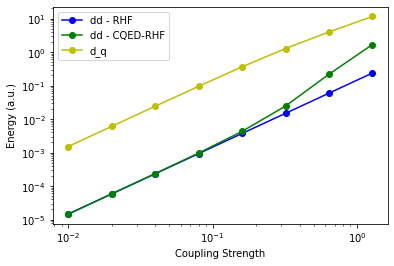

In [4]:

plt.plot(lam_vals, dde_rhf, 'bo-', label="dd - RHF")
plt.plot(lam_vals, dde_cqed_rhf, 'go-', label="dd - CQED-RHF")
plt.plot(lam_vals, dse, 'yo-', label="d_q")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Coupling Strength")
plt.ylabel("Energy (a.u.)")
plt.legend()
print(lam_vals)
print(dde_rhf)

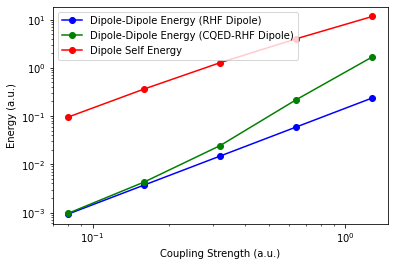

In [8]:
plt.plot(lam_vals[3:], dde_rhf[3:], 'bo-', label="Dipole-Dipole Energy (RHF Dipole)")
plt.plot(lam_vals[3:], dde_cqed_rhf[3:], 'go-', label="Dipole-Dipole Energy (CQED-RHF Dipole)")
plt.plot(lam_vals[3:], dse[3:], 'ro-', label="Dipole Self Energy")
#plt.plot(N, lam_of_rho, 'ro-', label="lambda")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Coupling Strength (a.u.)")
plt.ylabel("Energy (a.u.)")
plt.legend()

In [ ]:
plt.plot(N, lam, label="lambda")
plt.xscale('log')
plt.legend()

In [ ]:
Mol = []
for nvals in N:
    Mol.append(nvals/(V_l* 6.022e23))
    
print(Mol)

In [ ]:
plt.plot(Mol, dde_rhf, 'bo-', label="Dipole-Dipole Energy (RHF Dipole)")
plt.plot(Mol, dde_cqed_rhf, 'go-', label="Dipole-Dipole Energy (CQED-RHF Dipole)")
plt.plot(Mol, dse, 'ro-', label="Dipole Self Energy")
#plt.plot(N, lam_of_rho, 'ro-', label="lambda")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Molarity")
plt.ylabel("Energy in Atomic Units")
plt.legend()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from __future__ import print_function

"""
A script to run cqed_rhf method on the formaldehyde coupled to a photon with 
different polarizations and coupling magnitude |\lambda| = 0.2 atomic units
to produce data from Table I of McTague and Foley 
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cs_cqed_cis import *
from matplotlib import pyplot as plt

# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2

# rhf/cc-pVDZ optimized geometry of formaldehyde
molstr = """

0 1
    O      0.000000000000   0.000000000000  -0.068516219320
    H      0.000000000000  -0.790689573744   0.543701060715
    H      0.000000000000   0.790689573744   0.543701060715
no_reorient
symmetry c1
"""

# options dict
options_dict = {'basis': 'aug-cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 5e-7,
               'd_convergence' : 5e-6}

# define some constants here in atomic units

# cavity volume
V = 8.4e11

# photon energy of a 500 nm photon
homega = 0.09

# 1 / epsilon_0
oereps = 4 * np.pi

# dipole moment of hypothetical molecule
mu = 1.
Dn = np.linspace(8.5,11.5,13)
print(Dn)

In [ ]:
N = []
rho = []
g_of_rho = []
m_of_rho = []

# lambda vs rho
lam = []

# dipole self energy vs rho
dse = []

# dipole-dipole energy from rhf dipole (no cavity effect)
dde_rhf = []

# dipole-dipole energy from cqed-rhf dipole (cavity effect included)
dde_cqed_rhf = []

no_lam = np.array([0, 0, 0])

# this will get the rhf result because there is no cavity effect
rhf_dict = cqed_rhf(no_lam, molstr, options_dict)

# scan through number of molecules in the cavity and compute 
# g(\rho), \mu(\rho), d_q(\rho), and \lambda(\rho)

for i in Dn:

    # number of molecules
    N_val = 10 ** i
    N.append(N_val)
    
    # density
    rho_val = N_val / V
    rho.append(rho_val)
    
    # g(\rho)
    g_of_rho.append( np.sqrt(2 * homega * oereps) * mu * np.sqrt(rho_val))
    
    # ==> simple estimates of dipole-dipole energy and dipole self energy <==
    # \mu(\rho) simple model
    #m_of_rho.append( mu ** 2 * oereps * rho_val)
    # d_q of rho simple model
    #d_q_of_rho.append(4 * rho_val * oereps * mu ** 2)
    
    # lambda from density
    l = np.sqrt(4 * rho_val * oereps)
    lam.append(l)
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("Rho is ", rho_val)
    print("lambda is ",l)
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    
    # define lambda vector as pointing along y and z
    lam_yz = np.array([0, l/np.sqrt(2), l/np.sqrt(2)])
    
    # run cqed-rhf calculation with lam_yz
    cqed_dict_yz = cqed_rhf(lam_yz, molstr, options_dict)
    
    # get RHF dipole-dipole energy
    mu_rhf = cqed_dict_yz['RHF DIPOLE MOMENT']
    mu_dot_mu = np.dot(mu_rhf, mu_rhf)
    dde_rhf.append(mu_dot_mu * oereps * rho_val)
    
    # get CQED-RHF dipole-dipole energy
    mu_cqed_rhf = cqed_dict_yz['CQED-RHF DIPOLE MOMENT']
    mu_dot_mu = np.dot(mu_cqed_rhf, mu_cqed_rhf)
    dde_cqed_rhf.append(mu_dot_mu * oereps * rho_val)
    
    # get dipole self energy
    d_q = cqed_dict_yz["1E DIPOLE ENERGY"] + cqed_dict_yz["2E DIPOLE ENERGY"]
    d_q += cqed_dict_yz["1E QUADRUPOLE ENERGY"] + cqed_dict_yz["DIPOLE ENERGY"]

    dse.append(d_q)
    
    #print(N, rho, g_of_rho, m_of_rho, d_q_of_rho, lam_of_rho)
plt.plot(N, dde_rhf, 'bo-', label="dd - RHF")
plt.plot(N, dde_cqed_rhf, 'go-', label="dd - CQED-RHF")
plt.plot(N, dse, 'yo-', label="d_q")
#plt.plot(N, lam_of_rho, 'ro-', label="lambda")
plt.xscale('log')
plt.yscale('log')
plt.legend()


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from __future__ import print_function

"""
A script to run cqed_rhf method on the formaldehyde coupled to a photon with 
different polarizations and coupling magnitude |\lambda| = 0.2 atomic units
to produce data from Table I of McTague and Foley 
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cs_cqed_cis import *
from matplotlib import pyplot as plt

# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2

# rhf/cc-pVDZ optimized geometry of formaldehyde
molstr = """

1 1
    Mg      0.000000000000   0.000000000000  -0.900000000000
    H       0.000000000000   0.000000000000   0.900000000000
no_reorient
symmetry c1
"""

# options dict
options_dict = {'basis': 'aug-cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 5e-7,
               'd_convergence' : 5e-6}

# define some constants here in atomic units

# cavity volume
V = 8.4e11

# photon energy of a 500 nm photon
homega = 0.09

# 1 / epsilon_0
oereps = 4 * np.pi

# dipole moment of hypothetical molecule
mu = 1.
Dn = np.linspace(8.5,11.5,13)
print(Dn)

In [ ]:
N = []
rho = []
g_of_rho = []
m_of_rho = []

# lambda vs rho
lam = []

# dipole self energy vs rho
dse = []

# dipole-dipole energy from rhf dipole (no cavity effect)
dde_rhf = []

# dipole-dipole energy from cqed-rhf dipole (cavity effect included)
dde_cqed_rhf = []

no_lam = np.array([0, 0, 0])

# this will get the rhf result because there is no cavity effect
rhf_dict = cqed_rhf(no_lam, molstr, options_dict)

# scan through number of molecules in the cavity and compute 
# g(\rho), \mu(\rho), d_q(\rho), and \lambda(\rho)

for i in Dn:

    # number of molecules
    N_val = 10 ** i
    N.append(N_val)
    
    # density
    rho_val = N_val / V
    rho.append(rho_val)
    
    # g(\rho)
    g_of_rho.append( np.sqrt(2 * homega * oereps) * mu * np.sqrt(rho_val))
    
    # ==> simple estimates of dipole-dipole energy and dipole self energy <==
    # \mu(\rho) simple model
    #m_of_rho.append( mu ** 2 * oereps * rho_val)
    # d_q of rho simple model
    #d_q_of_rho.append(4 * rho_val * oereps * mu ** 2)
    
    # lambda from density
    l = np.sqrt(4 * rho_val * oereps)
    lam.append(l)
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("Rho is ", rho_val)
    print("lambda is ",l)
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    
    # define lambda vector as pointing along y and z
    lam_yz = np.array([0, l/np.sqrt(2), l/np.sqrt(2)])
    
    # run cqed-rhf calculation with lam_yz
    cqed_dict_yz = cqed_rhf(lam_yz, molstr, options_dict)
    
    # get RHF dipole-dipole energy
    mu_rhf = cqed_dict_yz['RHF DIPOLE MOMENT']
    mu_dot_mu = np.dot(mu_rhf, mu_rhf)
    dde_rhf.append(mu_dot_mu * oereps * rho_val)
    
    # get CQED-RHF dipole-dipole energy
    mu_cqed_rhf = cqed_dict_yz['CQED-RHF DIPOLE MOMENT']
    mu_dot_mu = np.dot(mu_cqed_rhf, mu_cqed_rhf)
    dde_cqed_rhf.append(mu_dot_mu * oereps * rho_val)
    
    # get dipole self energy
    d_q = cqed_dict_yz["1E DIPOLE ENERGY"] + cqed_dict_yz["2E DIPOLE ENERGY"]
    d_q += cqed_dict_yz["1E QUADRUPOLE ENERGY"] + cqed_dict_yz["DIPOLE ENERGY"]

    dse.append(d_q)
    
    #print(N, rho, g_of_rho, m_of_rho, d_q_of_rho, lam_of_rho)
plt.plot(N, dde_rhf, 'bo-', label="dd - RHF")
plt.plot(N, dde_cqed_rhf, 'go-', label="dd - CQED-RHF")
plt.plot(N, dse, 'yo-', label="d_q")
#plt.plot(N, lam_of_rho, 'ro-', label="lambda")
plt.xscale('log')
plt.yscale('log')
plt.legend()


In [ ]:
# rhf/cc-pVDZ optimized geometry of formaldehyde
molstr = """

1 1
    Mg      0.000000000000   0.000000000000  -0.900000000000
    F       0.000000000000   0.000000000000   0.900000000000
no_reorient
symmetry c1
"""

N = []
rho = []
g_of_rho = []
m_of_rho = []

# lambda vs rho
lam = []

# dipole self energy vs rho
dse = []

# dipole-dipole energy from rhf dipole (no cavity effect)
dde_rhf = []

# dipole-dipole energy from cqed-rhf dipole (cavity effect included)
dde_cqed_rhf = []

no_lam = np.array([0, 0, 0])

# this will get the rhf result because there is no cavity effect
rhf_dict = cqed_rhf(no_lam, molstr, options_dict)

# scan through number of molecules in the cavity and compute 
# g(\rho), \mu(\rho), d_q(\rho), and \lambda(\rho)

for i in Dn:

    # number of molecules
    N_val = 10 ** i
    N.append(N_val)
    
    # density
    rho_val = N_val / V
    rho.append(rho_val)
    
    # g(\rho)
    g_of_rho.append( np.sqrt(2 * homega * oereps) * mu * np.sqrt(rho_val))
    
    # ==> simple estimates of dipole-dipole energy and dipole self energy <==
    # \mu(\rho) simple model
    #m_of_rho.append( mu ** 2 * oereps * rho_val)
    # d_q of rho simple model
    #d_q_of_rho.append(4 * rho_val * oereps * mu ** 2)
    
    # lambda from density
    l = np.sqrt(4 * rho_val * oereps)
    lam.append(l)
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("Rho is ", rho_val)
    print("lambda is ",l)
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!")
    
    # define lambda vector as pointing along y and z
    lam_yz = np.array([0, l/np.sqrt(2), l/np.sqrt(2)])
    
    # run cqed-rhf calculation with lam_yz
    cqed_dict_yz = cqed_rhf(lam_yz, molstr, options_dict)
    
    # get RHF dipole-dipole energy
    mu_rhf = cqed_dict_yz['RHF DIPOLE MOMENT']
    mu_dot_mu = np.dot(mu_rhf, mu_rhf)
    dde_rhf.append(mu_dot_mu * oereps * rho_val)
    
    # get CQED-RHF dipole-dipole energy
    mu_cqed_rhf = cqed_dict_yz['CQED-RHF DIPOLE MOMENT']
    mu_dot_mu = np.dot(mu_cqed_rhf, mu_cqed_rhf)
    dde_cqed_rhf.append(mu_dot_mu * oereps * rho_val)
    
    # get dipole self energy
    d_q = cqed_dict_yz["1E DIPOLE ENERGY"] + cqed_dict_yz["2E DIPOLE ENERGY"]
    d_q += cqed_dict_yz["1E QUADRUPOLE ENERGY"] + cqed_dict_yz["DIPOLE ENERGY"]

    dse.append(d_q)
    
    #print(N, rho, g_of_rho, m_of_rho, d_q_of_rho, lam_of_rho)
plt.plot(N, dde_rhf, 'bo-', label="dd - RHF")
plt.plot(N, dde_cqed_rhf, 'go-', label="dd - CQED-RHF")
plt.plot(N, dse, 'yo-', label="d_q")
#plt.plot(N, lam_of_rho, 'ro-', label="lambda")
plt.xscale('log')
plt.yscale('log')
plt.legend()